📊 notebooks/visualize_baseline.ipynb

Bu kod şunları yapar:

Bar Grafiği: baseline_metrics.csv dosyasını okur, tüm modelleri F1 skoruna göre sıralayıp çizer.

Heatmap: En yüksek skoru alan modelin (SVM) confusion_matrix_SVM.csv dosyasını bulur ve ısı haritasına çevirir.

ROC Eğrisi (Özel Durum): ROC çizmek için CSV yetmez (olasılıklar lazım), bu yüzden kodun son kısmında sadece SVM'i hızlıca tekrar eğitip eğrisini çizer.

📊 Baseline Modellerinin Hata Matrisleri Çiziliyor...
Toplam 11 model bulundu: ['SVM', 'CNN', 'LR', 'MLP', 'VCLF', 'RF', 'XGB', 'DT', 'LGB', 'LSTM', 'GNB']


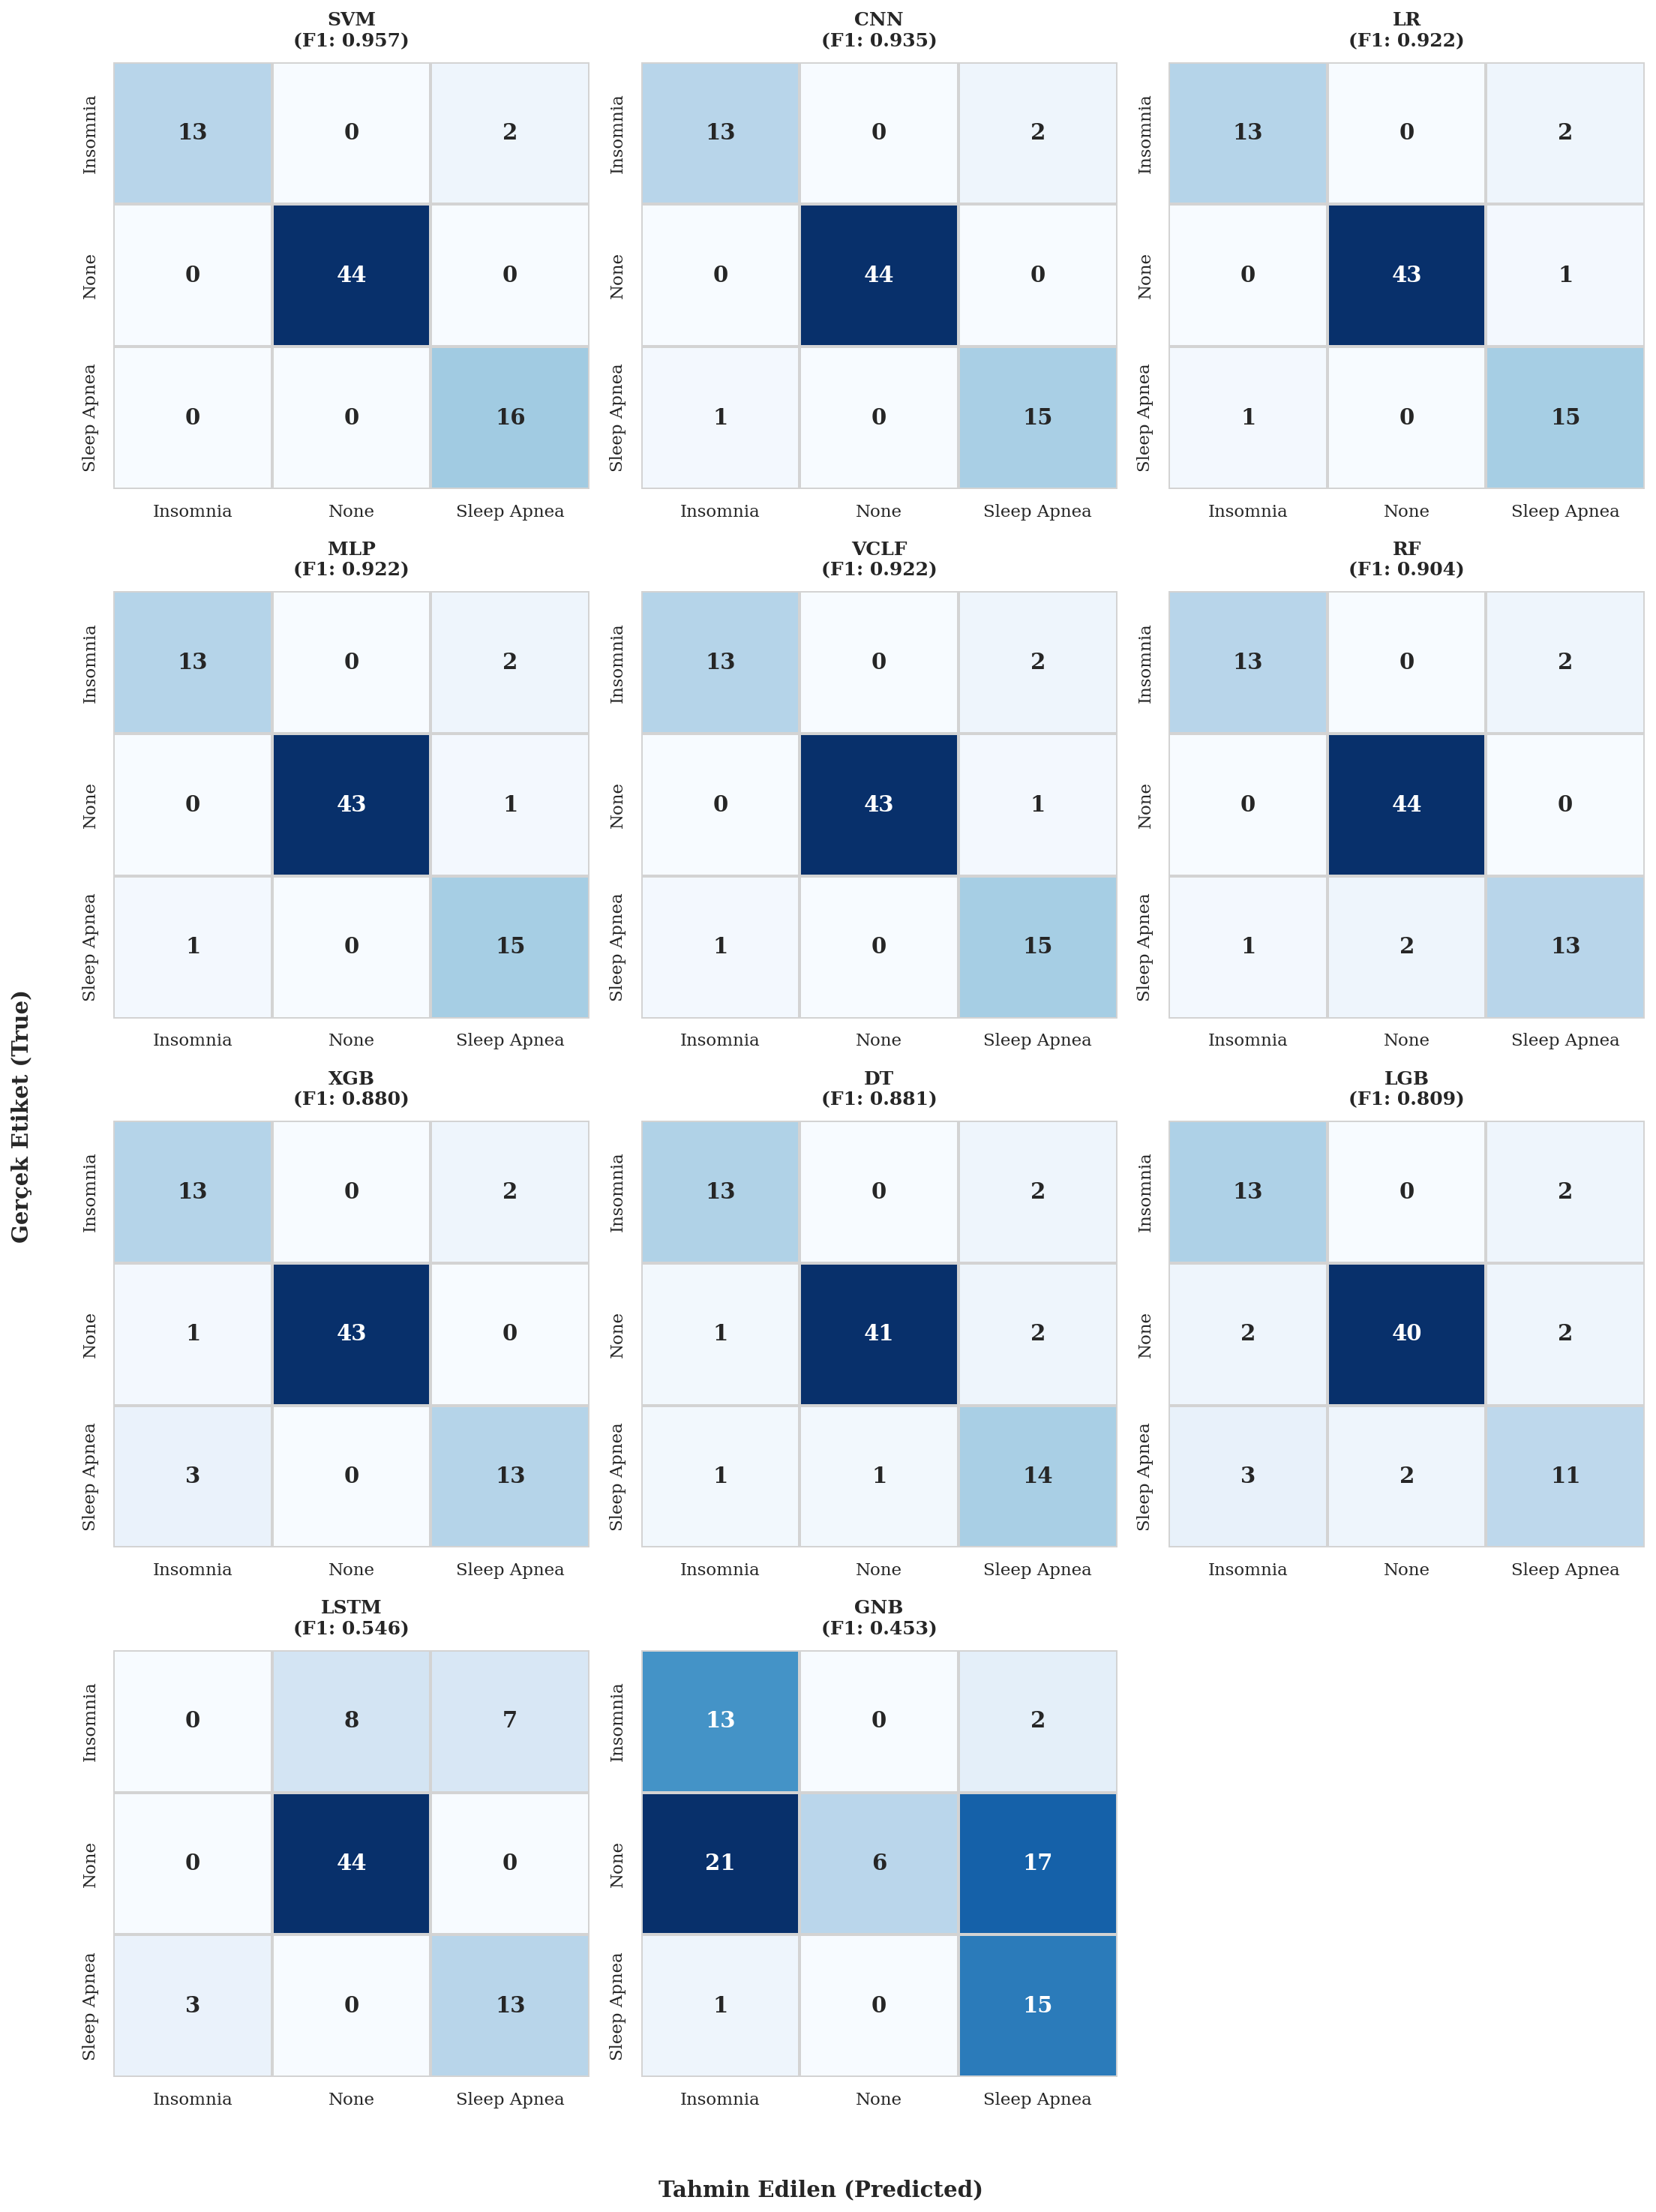

✅ Baseline görselleri kaydedildi: /Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/figures/confusion_matrices_all_baseline.png


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math

# Görsel Ayarları
sns.set(style="white")
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "serif"

# --- DOSYA YOLLARI ---
# SMOTE sonuçlarının olduğu klasör (run_baseline_smote.py buraya kaydetmişti)
# Eğer klasör ismini değiştirdiysen burayı güncelle!
METRICS_PATH = "/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/tables-baseline/baseline_metrics.csv"
TABLES_DIR = "/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/tables-baseline" 

print("📊 Baseline Modellerinin Hata Matrisleri Çiziliyor...")

if os.path.exists(METRICS_PATH):
    # 1. Metrikleri Oku
    df_metrics = pd.read_csv(METRICS_PATH)
    # Accuracy skoruna göre sıralayalım ki en iyiler başta çıksın.
    df_sorted = df_metrics.sort_values(by = "accuracy", ascending = False)
    models = df_sorted["model"].tolist()

    print(f"Toplam {len(models)} model bulundu: {models}")



    # 2. Grid Ayarları
    num_plots = len(models)
    n_cols = 3
    n_rows = math.ceil(num_plots / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() 
    
    cmap = "Blues" # Baseline için Mavi tonu (Güveni/İstikrarı simgelesin)

    for i, model_name in enumerate(models):
        score = df_sorted.loc[df_sorted['model'] == model_name, 'f1_macro'].values[0]
        
        # Dosya adını oluştur: confusion_matrix_SVM_SMOTE.csv
        cm_filename = f"confusion_matrix_{model_name}.csv"
        cm_path = os.path.join(TABLES_DIR, cm_filename)
        
        ax = axes[i]
        
        if os.path.exists(cm_path):
            cm_df = pd.read_csv(cm_path, index_col=0, na_filter=False)
            
            sns.heatmap(
                cm_df, 
                annot=True, 
                fmt="d", 
                cmap=cmap, 
                cbar=False, 
                ax=ax, 
                linewidths=1, 
                linecolor='lightgray',
                annot_kws={"size": 14, "weight": "bold"}
            )
            
            # Başlığı temizle (SVM_SMOTE -> SVM + SMOTE)
            clean_name = model_name.replace("_SMOTE", " + SMOTE")
            ax.set_title(f"{clean_name}\n(F1: {score:.3f})", fontweight='bold', size=12, pad=10)
            ax.set_xlabel(""); ax.set_ylabel("")
            
        else:
            ax.text(0.5, 0.5, "Dosya Yok", ha='center', va='center', color='red')
            ax.set_title(model_name)

    # Boş kalan grafikleri temizle
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ortak Eksen İsimleri
    fig.text(0.5, 0.02, 'Tahmin Edilen (Predicted)', ha='center', fontsize=14, fontweight='bold')
    fig.text(0.02, 0.5, 'Gerçek Etiket (True)', va='center', rotation='vertical', fontsize=14, fontweight='bold')

    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    
    save_path = "/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/figures/confusion_matrices_all_baseline.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Baseline görselleri kaydedildi: {save_path}")
else:
    print(f"❌ Dosya bulunamadı: {METRICS_PATH}")

📊 Modellerin ROC-AUC Skorları Karşılaştırılıyor (CSV'den Okunuyor)...


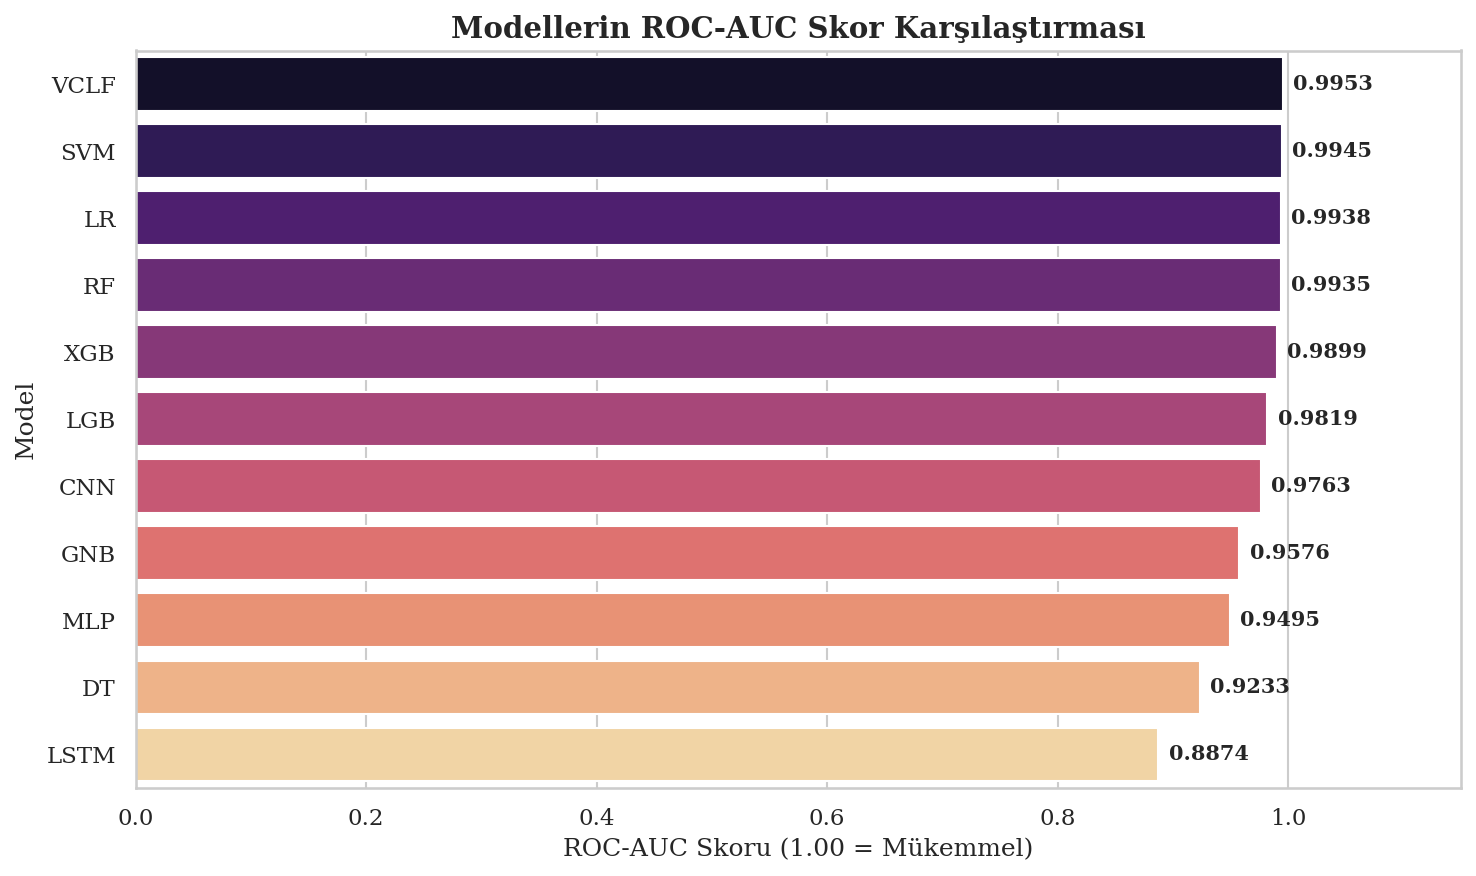

✅ Grafik kaydedildi: /Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/figures/roc_auc_scores_bar_baseline.png


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Görsel Ayarları
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "serif"

# Dosya Yolu
METRICS_PATH = "/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/tables-baseline/baseline_metrics.csv"

print("📊 Modellerin ROC-AUC Skorları Karşılaştırılıyor (CSV'den Okunuyor)...")

if os.path.exists(METRICS_PATH):
    # 1. CSV'yi Oku
    df = pd.read_csv(METRICS_PATH)
    
    # 2. ROC AUC Skoru boş olanları (NA) çıkar veya 0 yap
    df = df.dropna(subset=['roc_auc_ovr_macro'])
    
    # 3. Sıralama (En yüksek AUC en üstte olsun)
    df_sorted = df.sort_values(by="roc_auc_ovr_macro", ascending=False)
    
    # 4. Çizim Alanı
    plt.figure(figsize=(10, 6))
    
    # 5. Bar Plot Çizimi
    ax = sns.barplot(
        x="roc_auc_ovr_macro", 
        y="model", 
        data=df_sorted, 
        palette="magma", # Renk paleti (Magma: Koyu mor -> Turuncu)
        hue="model",
        legend=False
    )
    
    # 6. Başlık ve Etiketler
    plt.title("Modellerin ROC-AUC Skor Karşılaştırması", fontsize=14, fontweight='bold')
    plt.xlabel("ROC-AUC Skoru (1.00 = Mükemmel)")
    plt.ylabel("Model")
    plt.xlim(0.0, 1.15) # Yazılar sığsın diye sağda boşluk
    
    # 7. Çubukların ucuna tam puanı yaz
    for container in ax.containers:
        ax.bar_label(container, fmt="%.4f", padding=5, fontsize=10, fontweight='bold')

    plt.tight_layout()
    
    # 8. Kaydet ve Göster
    save_path = "/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/figures/roc_auc_scores_bar_baseline.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Grafik kaydedildi: {save_path}")
    
else:
    print(f"❌ HATA: {METRICS_PATH} dosyası bulunamadı!")

🗑️ 'Person ID' sütunu analizden çıkarıldı (Gürültü önlendi).


/var/folders/06/61zr6n0n0rs4fbl42p7szkfm0000gn/T/ipykernel_53723/45903364.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")


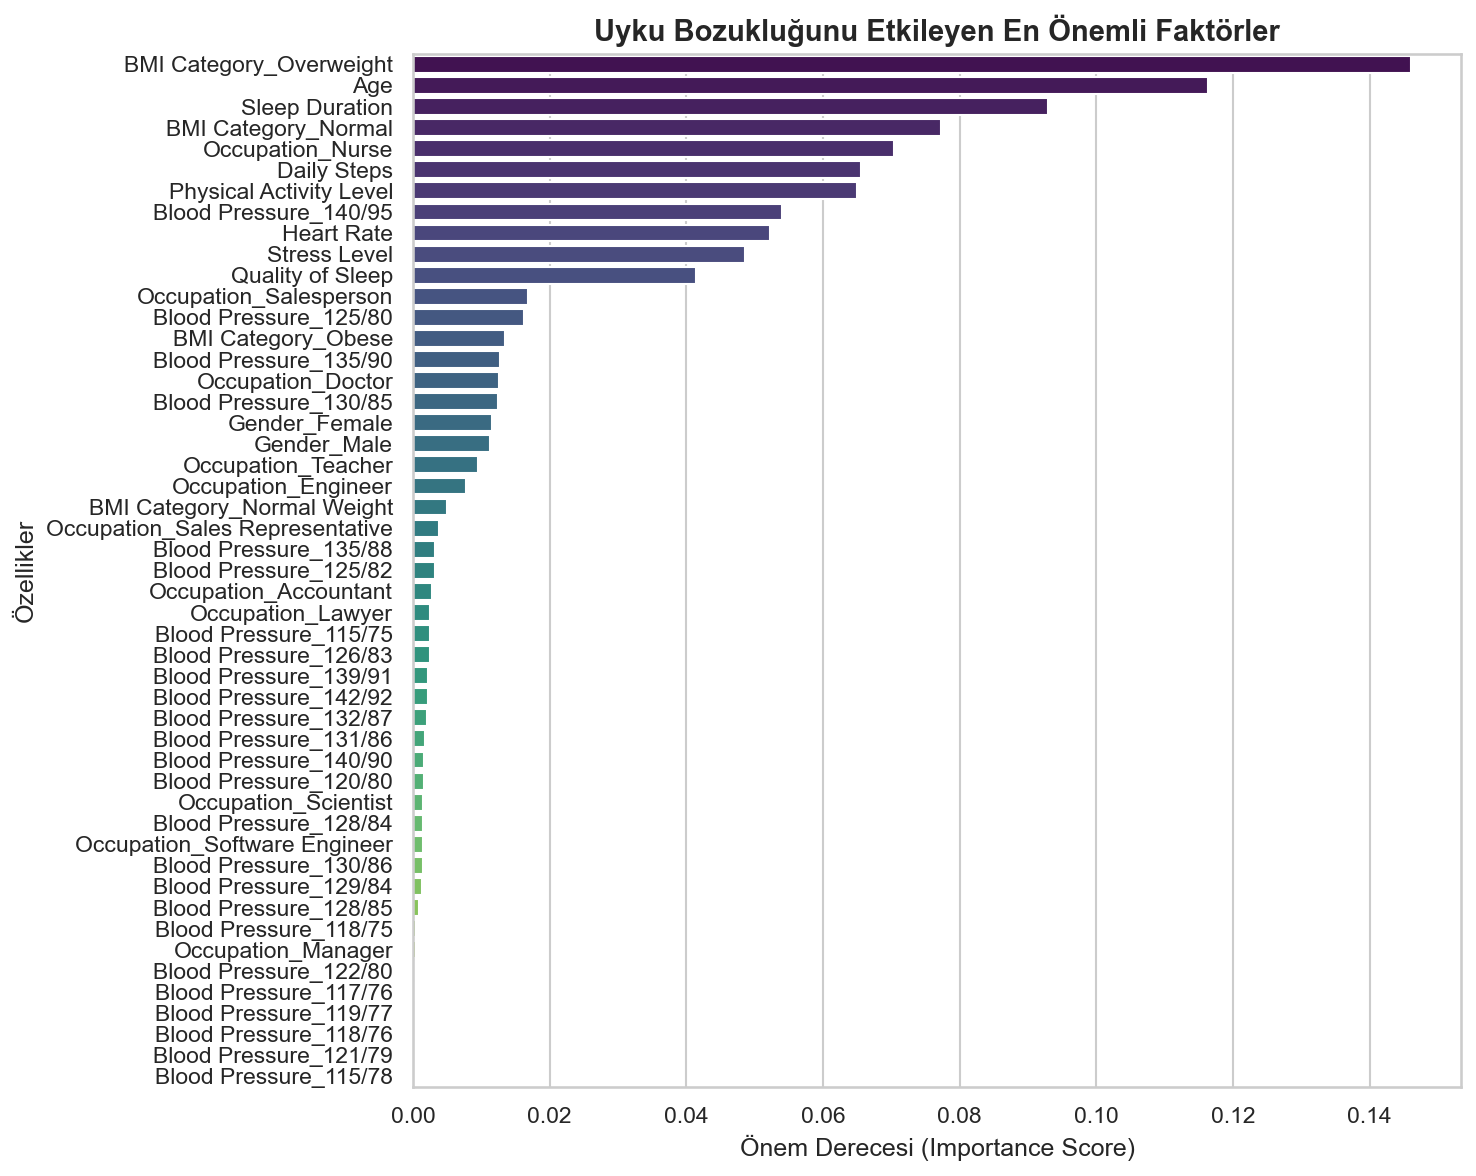

✅ Özellik önem görseli kaydedildi.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Yollar
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data_loader import load_raw_data
from src.preprocessing import split_features_target, build_preprocessor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Ayarlar
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# 1. Veri ve Model Hazırlığı
df = load_raw_data("/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/data/raw-data/Sleep_health_and_lifestyle_dataset.csv")
X, y = split_features_target(df)

# PersonID sütununu çıkar (varsa)
if "Person ID" in X.columns:
    X = X.drop("Person ID", axis=1)
    print("🗑️ 'Person ID' sütunu analizden çıkarıldı (Gürültü önlendi).")

# Label Encoding
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Ön İşleme (Pipeline olmadan manuel yapalım ki isimleri alabilelim)
preprocessor = build_preprocessor(X)
X_processed = preprocessor.fit_transform(X)

# Özellik İsimlerini Geri Al (Zor Kısım)
# OneHotEncoder yüzünden sütun sayısı arttı, isimleri bulmamız lazım
feature_names = []
transformers = preprocessor.transformers_

for name, trans, cols in transformers:
    if hasattr(trans, 'get_feature_names_out'):
        # OneHot olanlar
        feature_names.extend(trans.get_feature_names_out(cols))
    else:
        # Scaler olanlar (isim değişmez)
        feature_names.extend(cols)

# 2. Modeli Eğit (Random Forest - En iyi modellerden biri)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_processed, y_enc)

# 3. Önemi Çek
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] # Büyükten küçüğe sırala

# 4. Çiz
plt.title("Uyku Bozukluğunu Etkileyen En Önemli Faktörler", fontsize=14, fontweight='bold')
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")
plt.xlabel("Önem Derecesi (Importance Score)")
plt.ylabel("Özellikler")

plt.tight_layout()
plt.savefig("/Users/melih/Desktop/sleep-project/sleep-disorder-signal-processing/results/figures/feature_importance.png")
plt.show()
print("✅ Özellik önem görseli kaydedildi.")